In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/rt-example
!nvidia-smi
!pip install git+https://github.com/randommm/NNLLE.git

import os
import string
import pickle
import time

import numpy as np
from matplotlib import pyplot as plt

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from nnlocallinear import NLS

nltk.download('stopwords')
nltk.download('wordnet')

Mounted at /content/drive
/content/drive/My Drive/rt-example
Mon Aug 30 14:47:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                           

True

# Load and process data

In [2]:
if not os.path.isfile('./data/rt-polaritydata.tar.gz'):
    !wget 'http://www.cs.cornell.edu/People/pabo/movie-review-data/rt-polaritydata.tar.gz' -P 'data'
    !tar -xf data/rt-polaritydata.tar.gz -C 'data'

def load_polarity(path='./data/rt-polaritydata/'):
    data = []
    labels = []
    f_names = ['rt-polarity.neg', 'rt-polarity.pos']
    for (l, f) in enumerate(f_names):
        for line in open(os.path.join(path, f), 'rb'):
            data.append(line.decode('utf8', errors='ignore').strip())
            labels.append(l)
    return data, np.array(labels)

remove_punct = str.maketrans('', '', string.punctuation)
remove_digits = str.maketrans('', '', string.digits)
stops = stopwords.words('english')
wnl = WordNetLemmatizer()
def process_text(sentence):
    out = sentence.lower()
    out = out.translate(remove_punct)
    out = out.translate(remove_digits)
    out = [wnl.lemmatize(w) for w in out.split() if w not in stops]
    return ' '.join(out)

class VectorizeText():
    def __init__(self, limit=True, **kwargs):
      if limit:
        self.count_vect = CountVectorizer(min_df=0.003, max_df=0.997, **kwargs)
      else:
        self.count_vect = CountVectorizer(**kwargs)
      self.tf_transformer = TfidfTransformer(use_idf=False)
    def fit(self, x):
        x = self.count_vect.fit_transform(x)
        self.tf_transformer.fit(x)
    def transform(self, x):
        x = self.count_vect.transform(x)
        x = self.tf_transformer.transform(x)
        return x.toarray()     
    def get_feature_names(self):
        return vectorizer.count_vect.get_feature_names()

x, y = load_polarity()
split_idx = np.random.default_rng(0).binomial(size=len(y), n=1, p=0.8)

x_train = [process_text(x[i]) for i in range(len(x)) if split_idx[i] == 1]
x_test = [process_text(x[i]) for i in range(len(x)) if split_idx[i] == 0]

y_train = y[split_idx == 1]
y_test = y[split_idx == 0]

vectorizer = VectorizeText(limit=True)
vectorizer.fit(x_train)    
x_vec_train = vectorizer.transform(x_train) 
x_vec_test = vectorizer.transform(x_test)
names_features = np.array(vectorizer.get_feature_names())

print(f'Example sentence: {x_train[0]}')
print(f'Total number of features (words): {len(names_features)}')

Example sentence: simplistic silly tedious
Total number of features (words): 557


# Train models

In [ ]:
def train(penalization_thetas, x_train, y_train):
    parameters = {
        'es_give_up_after_nepochs': 6
        , 'hidden_size': 100
        , 'num_layers': 1
        , 'n_classification_labels': 2
        , 'penalization_thetas': penalization_thetas
    }
    model = NLS(
        verbose=10
        , optim_lr=1e-2 if penalty != 0 else 1e-3
        , nn_weight_decay=0 if penalty != 0 else 1e-2
        , es=True
        , batch_initial=128
        , batch_max_size=128
        , gpu=True
        , scale_data=False
        , varying_theta0=False
        , fixed_theta0=True
        , dataloader_workers=0
        , **parameters
    )
    model.fit(x_train=x_train, y_train=y_train)
    return model

penalty_grid = [0, 0.0002, 0.0005, 100]
for penalty in penalty_grid:
    start = time.time()
    model = train(penalty, x_vec_train, y_train)
    delta_time = time.time() - start
    with open(f'fitted/{penalty}.pkl', 'wb') as f:
        pickle.dump(model, f)
    print("Time: ", delta_time)

# Results

In [8]:
def test_model(model):
    y_pred = model.predict(x_vec_test)
    print('F1 Score:', metrics.f1_score(y_test, y_pred, average='binary'))
    print('Accuracy', metrics.accuracy_score(y_test, y_pred, normalize=True, sample_weight=None))

penalty_grid = ['0.pkl', '0.0002.pkl', '0.0005.pkl', '1000.pkl']
for penalty in penalty_grid:
    print(penalty)
    with open(os.path.join('fitted', penalty), 'rb') as f:
        model = pickle.load(f)
    test_model(model)

0.pkl
F1 Score: 0.6821631878557874
Accuracy 0.6880819366852886
0.0002.pkl
F1 Score: 0.6883545497406883
Accuracy 0.6922718808193669
0.0005.pkl
F1 Score: 0.6845574387947269
Accuracy 0.6880819366852886
1000.pkl
F1 Score: 0.6810709253170503
Accuracy 0.6838919925512105


## Example explanations

0.pkl


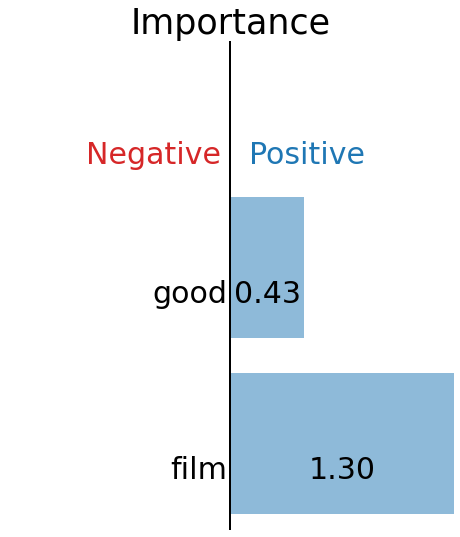

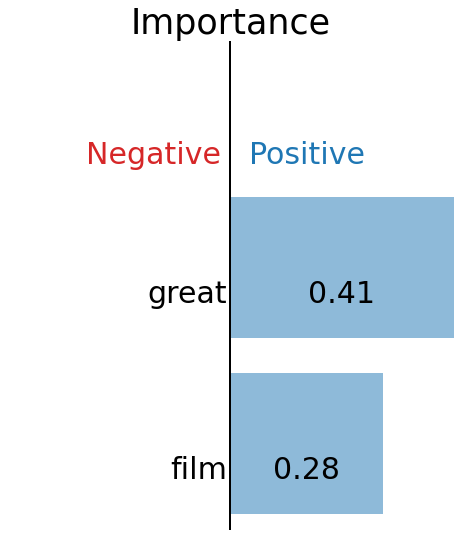

0.0002.pkl


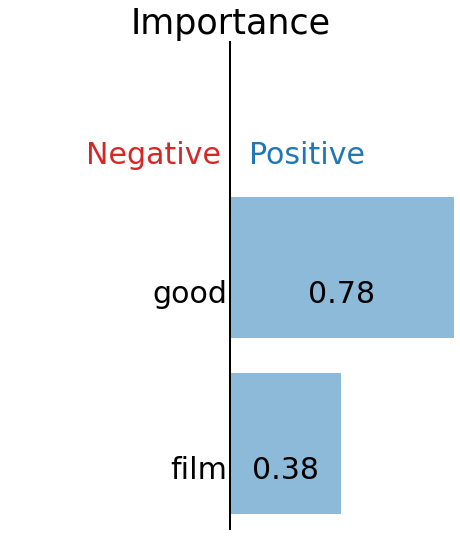

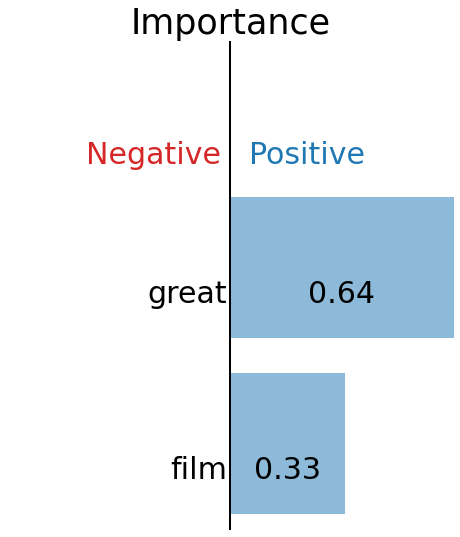

0.0005.pkl


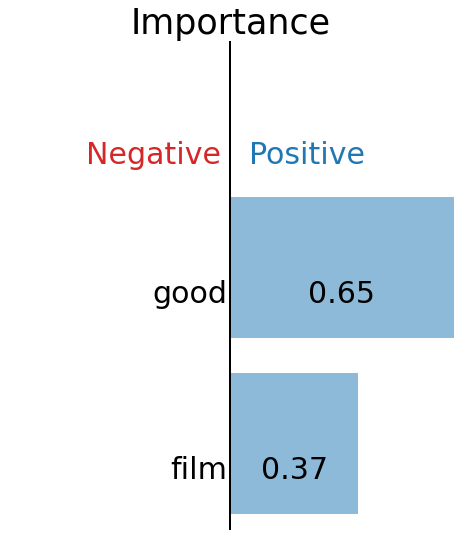

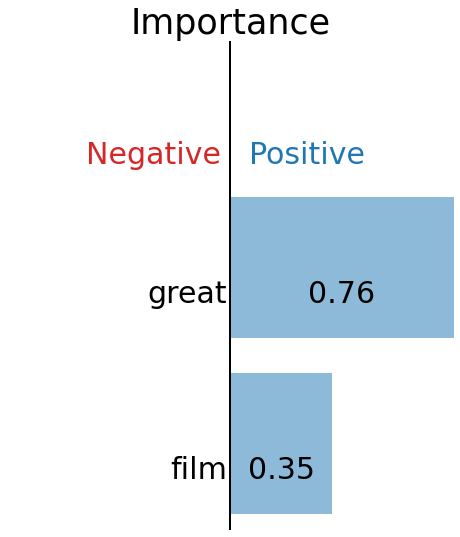

1000.pkl


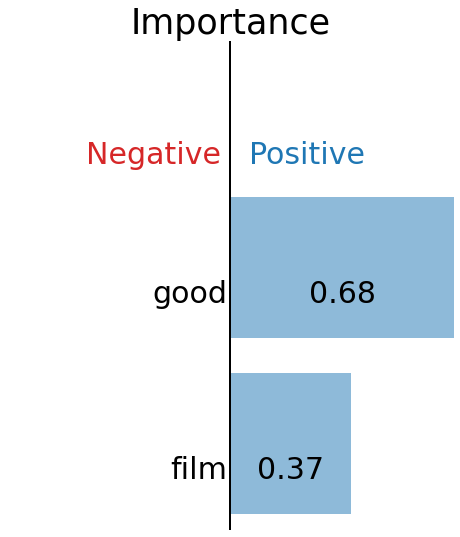

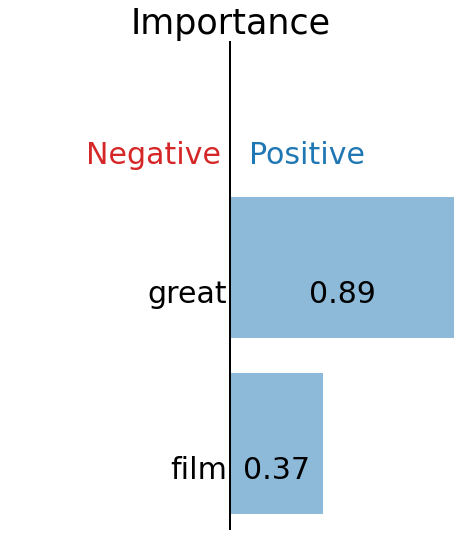

In [17]:
def get_explanation(x_explain, document, model, num_features=10):
        
    explanation = model.get_thetas(x_pred=x_explain, net_scale=True)
    betas = explanation[2][0]
    #print('len(betas)', len(betas))
    words_from_text_indices = np.argwhere(x_explain[0] != 0).reshape(-1)
    #print('len(words_from_text_indices)', len(words_from_text_indices))
    # Prediction from the model
    prediction = model.predict(x_explain).reshape(-1)
    predict_proba = model.predict_proba(x_explain).reshape(-1)
    ind_pred_proba = np.argsort(predict_proba)[::-1]
    #print('probabilities: ', ind_pred_proba)

    # print(f'Probability negative: {predict_proba[0]}; Probability positive: {predict_proba[1]}')
    # col_betas = int(prediction)
    col_betas = ind_pred_proba[0]
    col_betas_neg = ind_pred_proba[1]

    betas_document = betas[words_from_text_indices, col_betas]
    #print('betas_document len:', len(betas_document))
    betas_document_neg = betas[words_from_text_indices, col_betas_neg]

    betas_final = betas_document - betas_document_neg
    words_features_document = names_features[words_from_text_indices].reshape(-1)

    return dict(
        chi_names=words_features_document,
        chi_values=words_features_document,
        x_values=words_features_document,
        x_names=words_features_document,
        y_p=predict_proba[0],
        y_p_max=1.0,
        y_p_min=0.0,
        y_p_local_model=predict_proba[0],
        y_p_local_model_max=None,
        y_p_local_model_min=None,
        error=None,
        importances=betas_final,
        importances_rank1=betas_document,
        importances_rank2=betas_document_neg, 
        diff_convergence_importances=None,
        ind_class_sorted=0,
        class_names= ["probability"]
    )

def label_bar(rects, ax, labels=None, offset_y=0.4):
    colors = ["blue", "orange"]
    N = len(rects)
    if N > 28:
        font_size = 10
    else:
        font_size = 30
    for i in range(N):
        rect = rects[i]
        width = rect.get_width()
        if width != 0.0:
            text_width = "{:3.2f}".format(width)
        else:
            text_width = ""
        x = rect.get_width() / 2.0
        if abs(x) <= 0.06:
            x = x / abs(x) * 0.10

        y = (rect.get_y() + rect.get_height() / 2) - 0.225
        xy = (x, y)

        ax.annotate(
            text_width,
            xy=xy,
            xytext=(0, -1),  # 3 points vertical offset
            textcoords="offset points",
            # ha="center",
            va="bottom",
            size=font_size,
            color="black",
            horizontalalignment="center",
        )
        if rect.get_width() > 0:
            aling_text = "right"
            off_setx = -3
        else:
            aling_text = "left"
            off_setx = +3
        if labels is not None:
            text = labels[i]
            ax.annotate(
                text,
                xy=(rect.get_x(), y),
                xytext=(off_setx, -1),  # 3 points vertical offset
                textcoords="offset points",
                horizontalalignment=aling_text,
                verticalalignment="bottom",
                size=font_size)

def simpleaxis(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

def plot_feature_importance(ax, names, vals, size_title=18):
    colors = ["tab:blue" if x > 0 else "tab:red" for x in vals]
    pos = np.arange(len(vals))
    rects2 = ax.barh(pos, vals, align="center", alpha=0.5, color=colors)

    label_bar(rects2, ax, labels=names)
    ax.axvline(0, color="black", lw=2)

    x_lim = np.max(np.abs(vals[:]))
    ax.set_xlim(-x_lim, x_lim)
    y_lim = np.array(ax.get_ylim())
    ax.set_ylim(y_lim + np.array([0, 0.8]))

    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_xticklabels([])

    ax.annotate("  Positive ", xy=(0, y_lim[1] + 0.1), size=30, color="tab:blue", ha="left")
    ax.annotate("  Negative ", xy=(0, y_lim[1] + 0.1), size=30, color="tab:red", ha="right")
    simpleaxis(ax)
    return ax

def explanation(sentence, x, x_vec, model, name):
    
    feature_names=[f'{e}: {word}' for e, word in enumerate(x.split())]
    words=np.array([f'{word}' for e, word in enumerate(x.split())])
    
    explain_dict = get_explanation(x_vec, sentence, model, num_features=13)
    
    fig, ax = plt.subplots(figsize=(8, 9))
    ax.set_title('Importance', fontsize=35)
    names = explain_dict['chi_names']
    importances = explain_dict['importances']
    ax = plot_feature_importance(ax=ax, names=names, vals=importances, size_title=15)
    plt.savefig(f'img/{name}.pdf')
    plt.show()

def process_explain(sentence, save_to):
    x_ = process_text(sentence)
    x__vec = vectorizer.transform([x_])
    explanation(sentence, x_, x__vec, model, save_to)

for penalty in penalty_grid:
    print(penalty)
    with open(os.path.join('fitted', penalty), 'rb') as f:
      model = pickle.load(f)
    process_explain('good film', f'{penalty}_good')
    process_explain('great film', f'{penalty}_great')

## Explanations from data

In [ ]:
std_importance = np.empty((len(penalty_grid), len(names_features)))
for i, penalty in enumerate(penalty_grid):
    with open(os.path.join('fitted', penalty), 'rb') as f:
      model = pickle.load(f)
    weights = model.get_thetas(x_pred=x_vec_test, net_scale=True)[2]
    for idx, word in enumerate(names_features):
        has_word = (x_vec_test[:, idx] != 0).flatten()
        std_importance[i, idx] = weights[:, idx, 1].std()

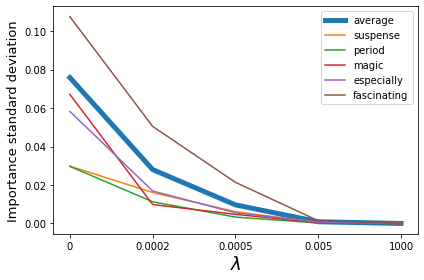

In [ ]:
sample_words = np.random.default_rng(0).integers(len(names_features), size=5)
f, ax = plt.subplots()
ax.plot(std_importance.mean(1), label='average', linewidth=5)
ax.set_xlabel(r'$\lambda$', fontsize=18)
ax.set_ylabel('Importance standard deviation', fontsize=13)
ax.set_xticks(np.arange(5)) 
ax.set_xticklabels([x.replace('.pkl', '') for x in penalty_grid])
for word_id in sample_words:
    ax.plot(std_importance[:, word_id], label=names_features[word_id])
ax.legend()
f.tight_layout()
f.savefig('img/words_std.pdf')